In [68]:
import os
import pandas as pd
import json
from tensorboard.backend.event_processing import event_accumulator

# Specify the path to your logs
log_dir = "/Users/agreic/Desktop/testing_dir/logs/aggregated_logs"

# find all json files in the directory, these have the runner_params
json_files = [f for f in os.listdir(log_dir) if f.endswith('.json')]
# For each json file, extract the Marker and the associated learning rate for each instance

marker_instance_learning_rate = []

for file in json_files:
    with open(os.path.join(log_dir, file), 'r') as f:
        data = json.load(f)
        
        # Extract instance
        for instance in range(1, len(data)+1):
            # print(instance)
            # Extract marker
            marker = data[str(instance)]['data'].split('/')[-1].replace('_setup.json', '').upper()
            if marker == 'GATA':
                marker = 'GATA1'
            if marker == 'PU':
                marker = 'PU1'
            if marker == 'SCA':
                marker = 'SCA1'
            if marker == 'CD412':
                marker = 'CD41'
                
            # print(marker)
            # Extract learning rate
            learning_rate = data[str(instance)]['learning_rate']
            # print(learning_rate)

            marker_instance_learning_rate.append([marker, instance, learning_rate])

# print(marker_instance_learning_rate)

# Initialize an empty list to store data
data = []

# Loop through all subdirectories and files to find TensorBoard logs
for root, dirs, files in os.walk(log_dir):
    for file in files:
        if "events" in file:
            event_path = os.path.join(root, file)
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            # Get the name of the parent directory of `root`
            parent_dir = os.path.basename(os.path.dirname(root)).replace("LR_Model_", "").replace("_logs", "")

            # Extract scalars and add them to the data list
            for tag in ea.Tags()["scalars"]:
                for scalar_event in ea.Scalars(tag):
                    data.append({
                        "tag": tag,
                        "step": scalar_event.step,
                        "value": scalar_event.value,
                        "file": parent_dir  # Use the parent directory name
                    })

# Convert to a DataFrame
df = pd.DataFrame(data)
print(df.head())

# Create a color column
# Starting palette with distinct colors for single markers
palette = {
    "PU1": "#1f77b4",   # muted blue
    "SCA1": "#ff7f0e",  # muted orange
    "GATA1": "#2ca02c", # muted green
    "CD41": "#d62728",   # muted red
    "None": "white"      # white for no markers
}

palette = {
    "PU1": "cyan",   # muted blue
    "SCA1": "green",  # muted orange
    "GATA1": "blue", # muted green
    "CD41": "pink",   # muted red
    "None": "white"      # white for no markers
}

# Initialize the color column
df['color'] = 'white'  # Default color for rows with no known markers

# Assign colors based on marker presence in the 'file' column
for marker, color in palette.items():
    df.loc[df['file'].str.contains(marker, case=False, na=False), 'color'] = color

# Select distinct shapes for up to 9 instances
distinct_shapes = ["o", "s", "p", "*", "D", "d", "H", "X", "h"]

# Initialize shape column and assign based on marker instances
df['shape'] = None
df['instance'] = df['file'].str.extract(r'_(\d+)$').astype(float)  # Extract instance number at end of 'file'
df['marker'] = df['file'].str.extract(r'^(.*?)_')[0].str.upper()  # Extract marker name at beginning of 'file'

# Map instances to shapes
instance_shape_map = {i + 1: shape for i, shape in enumerate(distinct_shapes)}
df['shape'] = df['instance'].map(instance_shape_map).fillna("o")  # Default to "o" if instance is missing

# Sort df by instance
df = df.sort_values("instance")

# Display the DataFrame to verify color and shape assignments
print(df.head())

                  tag  step     value   file
0           hp_metric     0 -1.000000  PU1_8
1  training_loss_step     9  0.562935  PU1_8
2  training_loss_step    19  0.571003  PU1_8
3  training_loss_step    29  0.560172  PU1_8
4  training_loss_step    39  0.565055  PU1_8
                        tag   step      value     file color shape  instance  \
415300  training_loss_epoch  62299   0.285459  GATA1_1  blue     o       1.0   
296789                epoch  61229  98.000000    PU1_1  cyan     o       1.0   
296788                epoch  61219  98.000000    PU1_1  cyan     o       1.0   
296787                epoch  61209  98.000000    PU1_1  cyan     o       1.0   
296786                epoch  61199  98.000000    PU1_1  cyan     o       1.0   

       marker  
415300  GATA1  
296789    PU1  
296788    PU1  
296787    PU1  
296786    PU1  


In [69]:
df[(df['marker'] == 'SCA1') & (df['instance'] == 8)]['tag'].unique()

array(['epoch', 'training_loss_step', 'training_loss_epoch', 'val_f1',
       'val_recall', 'val_precision', 'val_accuracy', 'val_fn', 'val_fp',
       'val_tn', 'val_tp', 'val_loss', 'hp_metric'], dtype=object)

In [70]:
print(marker_instance_learning_rate)

# initialize the learning_rate column
df['learning_rate'] = None

for item in marker_instance_learning_rate:
    marker, instance, learning_rate = item
    df.loc[(df['marker'] == marker) & (df['instance'] == instance), 'learning_rate'] = learning_rate

print(df.head())

[['GATA1', 1, 1e-05], ['GATA1', 2, 1e-06], ['GATA1', 3, 1e-07], ['GATA1', 4, 1e-05], ['GATA1', 5, 1e-06], ['GATA1', 6, 1e-07], ['GATA1', 7, 1e-05], ['GATA1', 8, 1e-06], ['GATA1', 9, 1e-07], ['CD41', 1, 1e-05], ['CD41', 2, 1e-06], ['CD41', 3, 1e-07], ['CD41', 4, 1e-05], ['CD41', 5, 1e-06], ['CD41', 6, 1e-07], ['CD41', 7, 1e-05], ['CD41', 8, 1e-06], ['CD41', 9, 1e-07], ['PU1', 1, 1e-05], ['PU1', 2, 1e-06], ['PU1', 3, 1e-07], ['PU1', 4, 1e-05], ['PU1', 5, 1e-06], ['PU1', 6, 1e-07], ['PU1', 7, 1e-05], ['PU1', 8, 1e-06], ['PU1', 9, 1e-07], ['SCA1', 1, 1e-05], ['SCA1', 2, 1e-06], ['SCA1', 3, 1e-07], ['SCA1', 4, 1e-05], ['SCA1', 5, 1e-06], ['SCA1', 6, 1e-07], ['SCA1', 7, 1e-05], ['SCA1', 8, 1e-06], ['SCA1', 9, 1e-07], ['CD41', 1, 1e-05], ['CD41', 2, 1e-06], ['CD41', 3, 1e-07], ['CD41', 4, 1e-05], ['CD41', 5, 1e-06], ['CD41', 6, 1e-07], ['CD41', 7, 1e-05], ['CD41', 8, 1e-06], ['CD41', 9, 1e-07]]
                        tag   step      value     file color shape  instance  \
415300  training_lo

In [71]:
print(df['marker'].unique())
# Rename CD412 to CD41
df['marker'] = df['marker'].replace('CD412', 'CD41')

['GATA1' 'PU1' 'SCA1' 'CD41' 'CD412']


GATA1


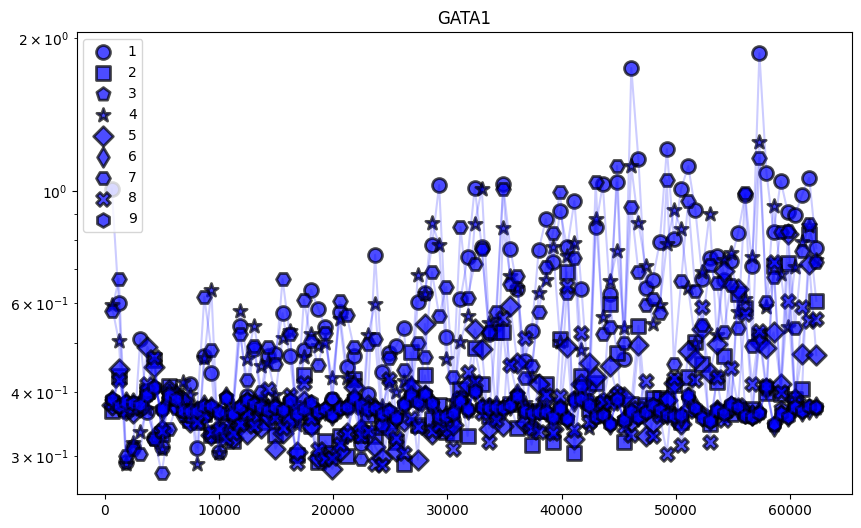

PU1


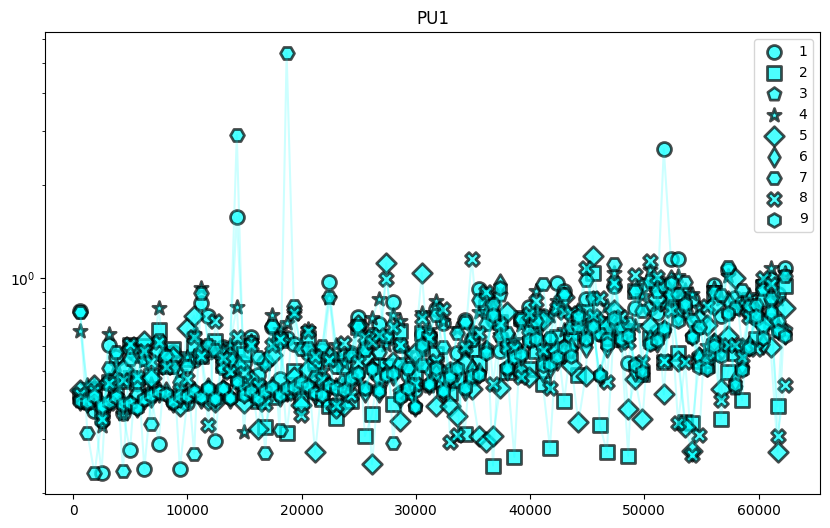

SCA1


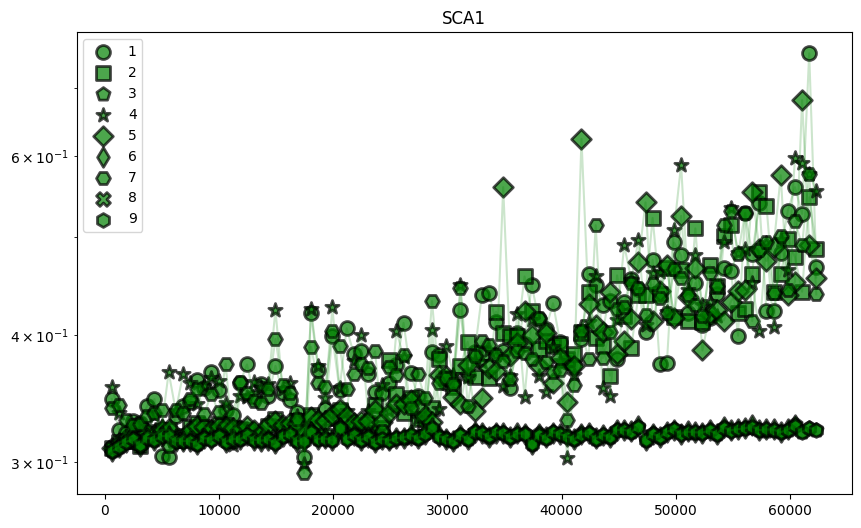

CD41


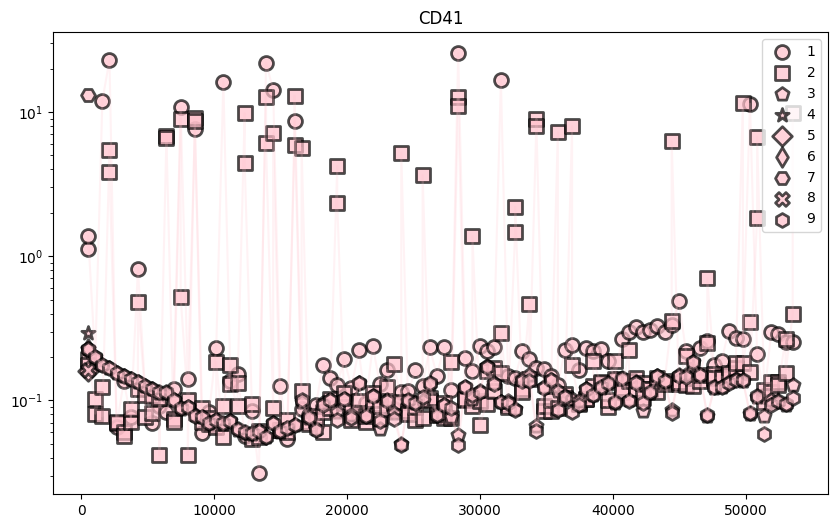

In [72]:
# For each marker, generate its own line + scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

for marker in df['marker'].unique():
    print(marker)
    # Filter the DataFrame to only include the current marker
    marker_df = df[df['marker'] == marker]
    # Filter to include metric of interest
    marker_df = marker_df[marker_df['tag'] == 'val_loss']

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    plt.title(f"{marker}")

    # Create the line plot
    for instance in marker_df['instance'].unique():
        instance_df = marker_df[marker_df['instance'] == instance]
        instance_df = instance_df.sort_values("step")
        plt.plot(instance_df['step'], instance_df['value'], color=palette[marker], linestyle='-', alpha=.2)
        plt.scatter(instance_df['step'], instance_df['value'], color=palette[marker], marker=instance_shape_map[instance], s=100, label=f'{int(instance)}', alpha=.7, edgecolor='black', linewidth=2)
    plt.yscale('log')
    plt.legend(title='')
    plt.show()

In [73]:
df

,tag,step,value,file,color,shape,instance,marker,learning_rate
415300,training_loss_epoch,62299,0.285459,GATA1_1,blue,o,1.0,GATA1,0.00001
296789,epoch,61229,98.000000,PU1_1,cyan,o,1.0,PU1,0.00001
296788,epoch,61219,98.000000,PU1_1,cyan,o,1.0,PU1,0.00001
296787,epoch,61209,98.000000,PU1_1,cyan,o,1.0,PU1,0.00001
296786,epoch,61199,98.000000,PU1_1,cyan,o,1.0,PU1,0.00001
...,...,...,...,...,...,...,...,...,...
207120,training_loss_step,33279,0.503048,GATA1_9,blue,h,9.0,GATA1,0.0
207119,training_loss_step,33269,0.309561,GATA1_9,blue,h,9.0,GATA1,0.0
207118,training_loss_step,33259,0.792022,GATA1_9,blue,h,9.0,GATA1,0.0
207116,training_loss_step,33239,0.477390,GATA1_9,blue,h,9.0,GATA1,0.0


100 100


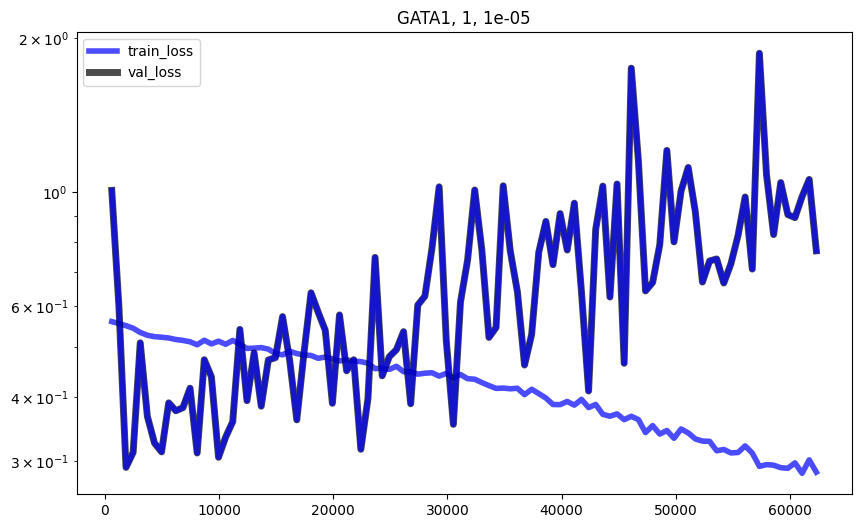

100 100


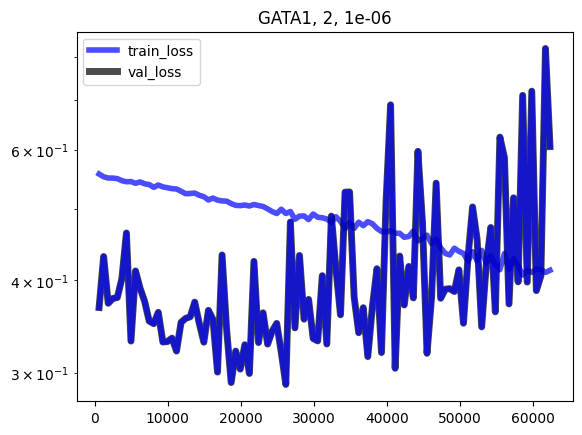

100 100


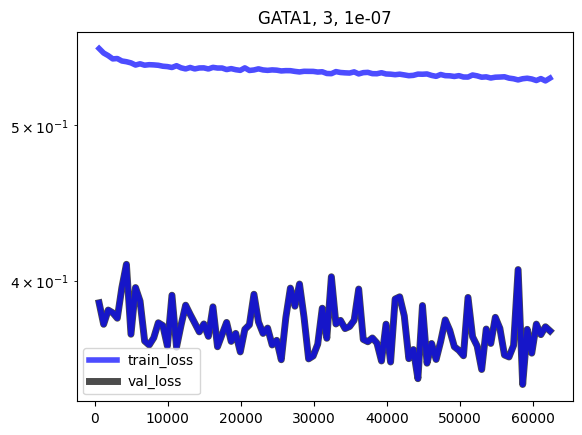

100 100


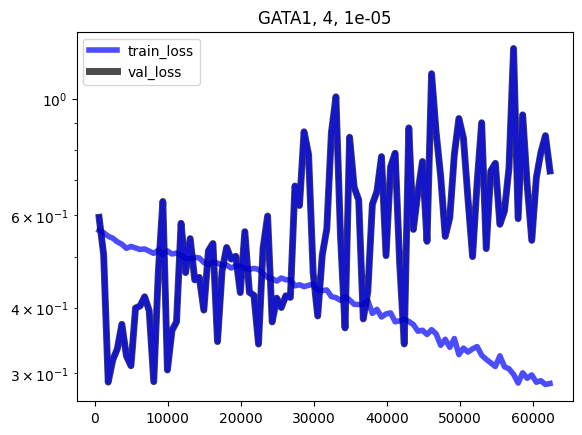

100 100


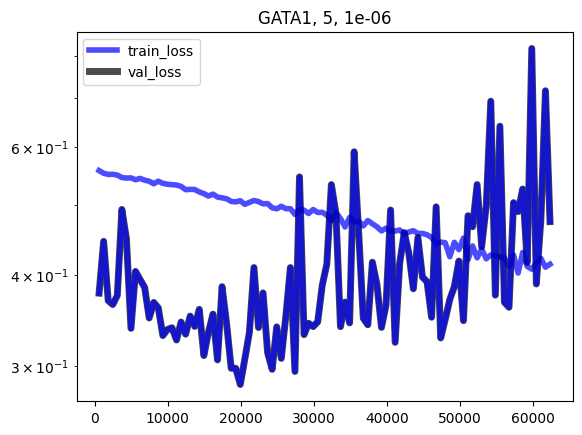

100 100


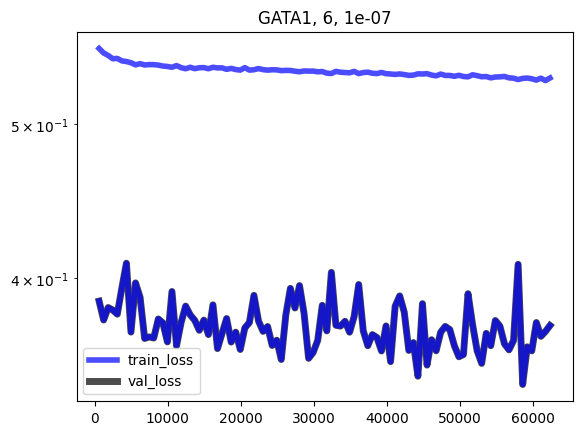

100 100


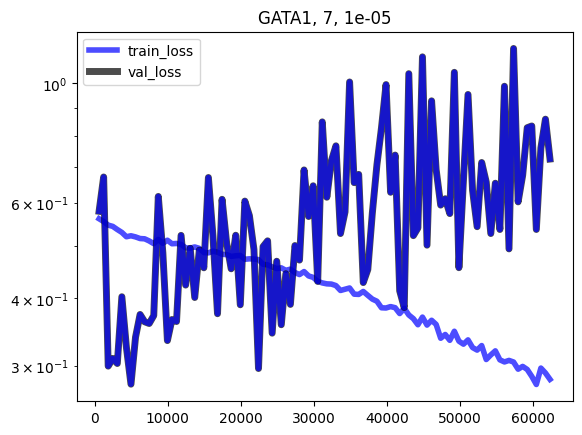

100 100


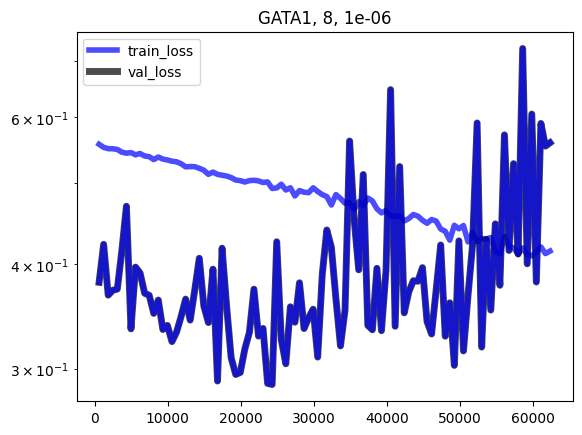

100 100


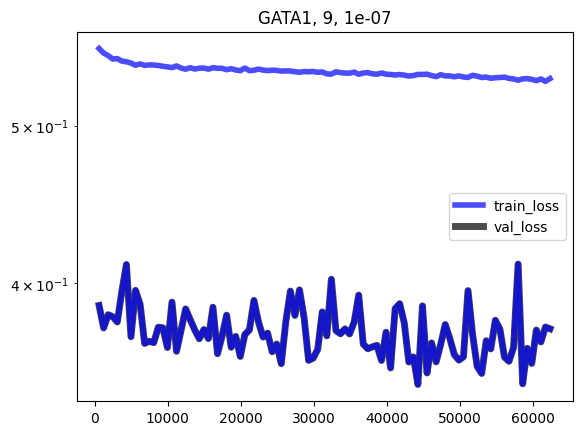

100 100


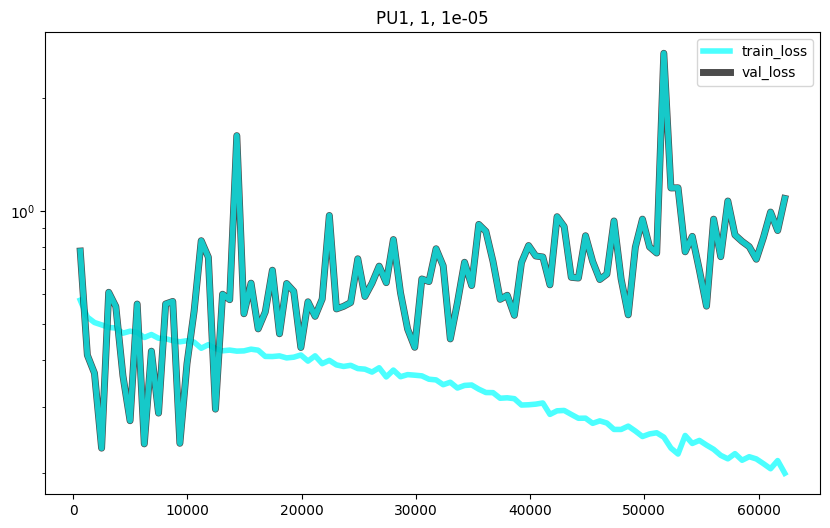

100 100


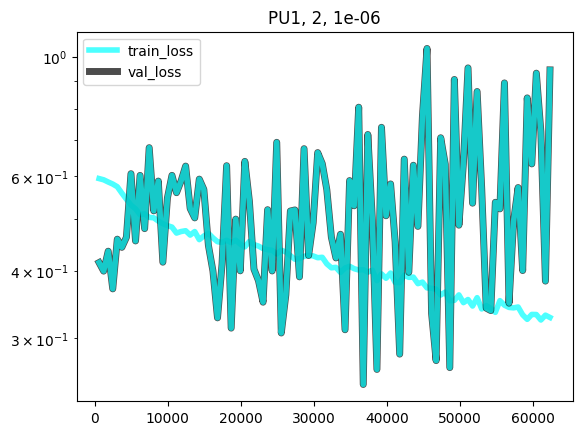

100 100


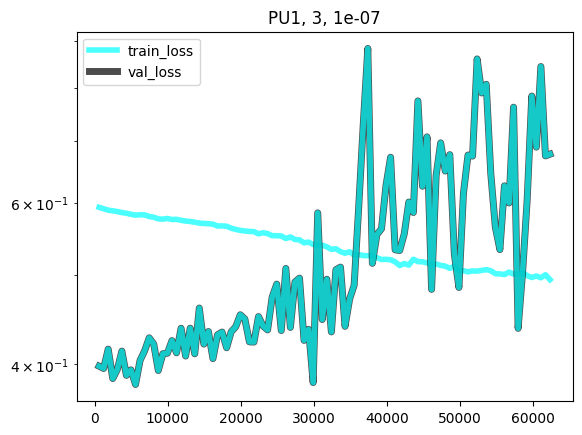

100 100


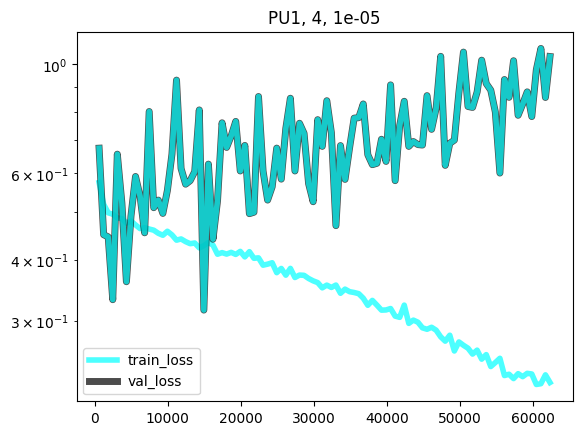

100 100


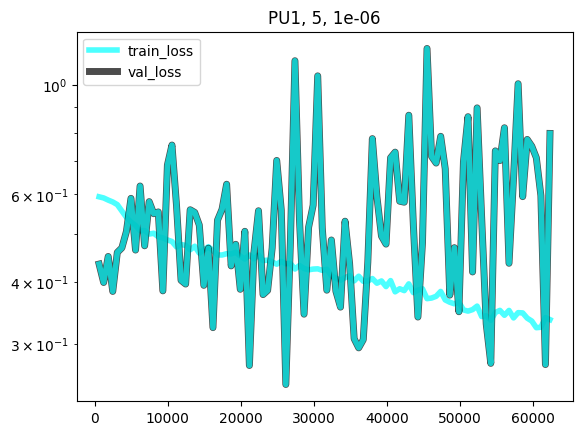

100 100


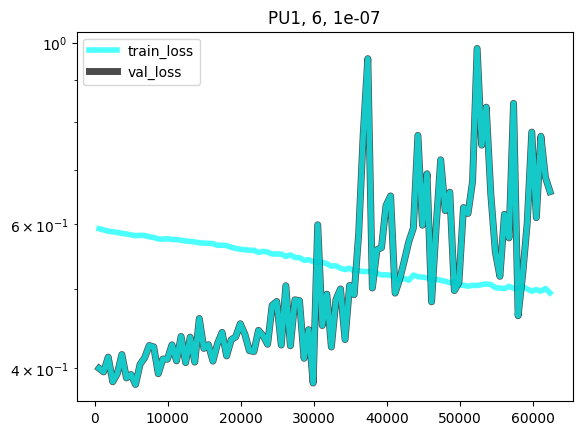

100 100


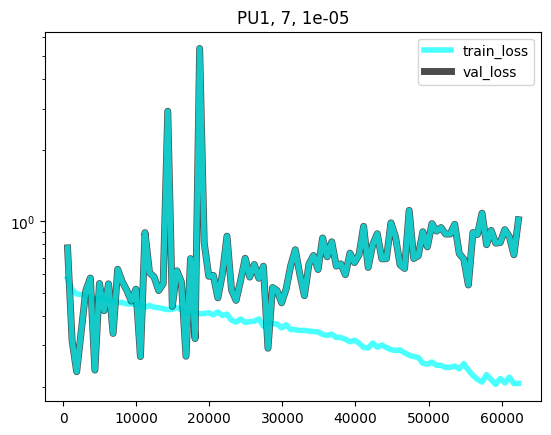

100 100


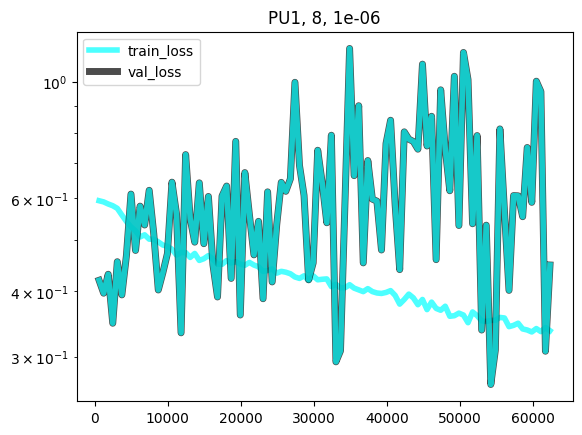

100 100


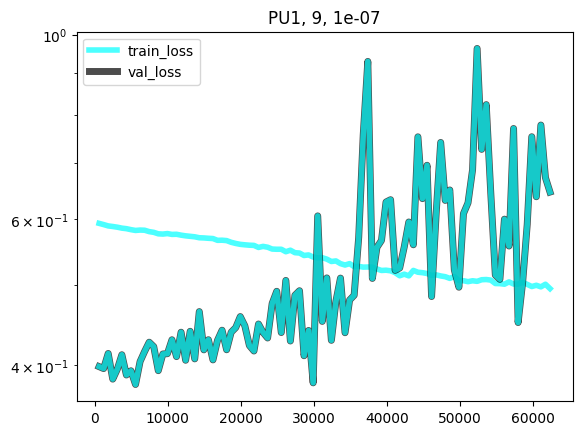

100 100


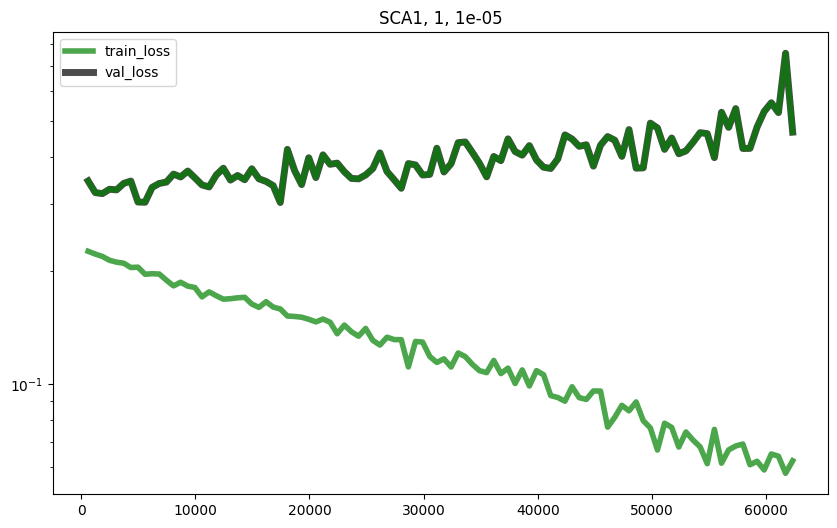

100 100


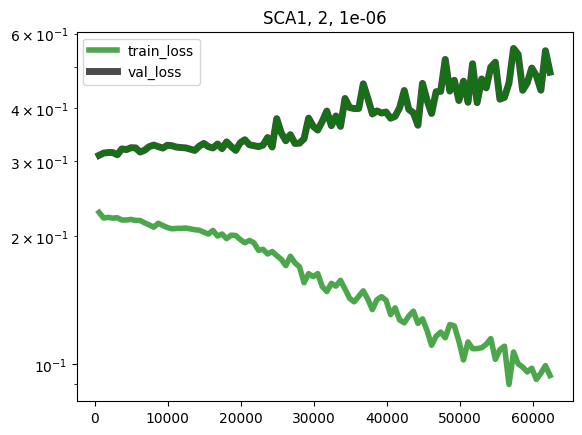

100 100


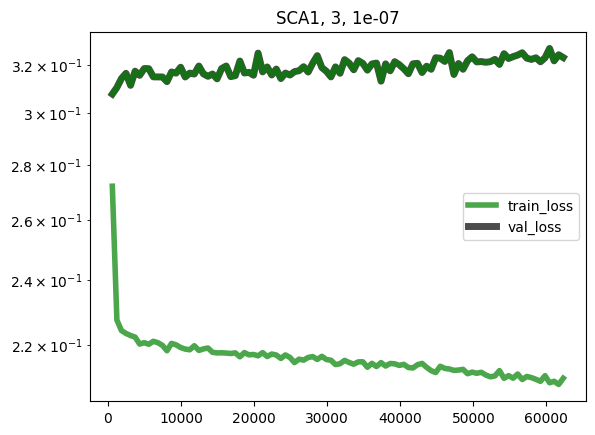

100 100


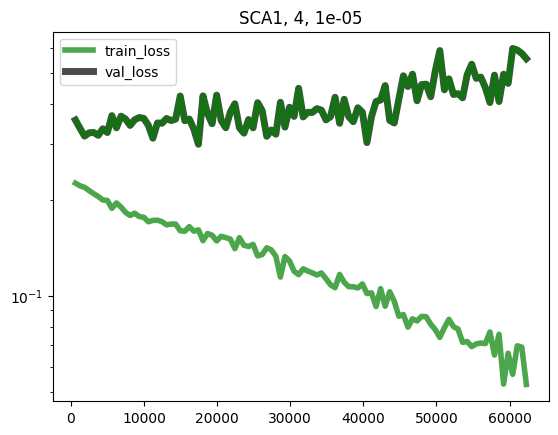

100 100


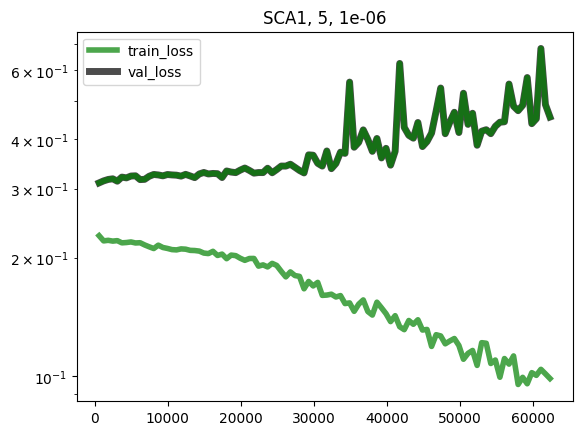

97 97


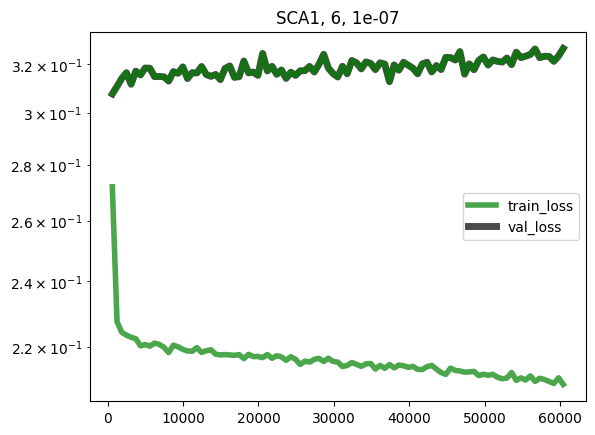

100 100


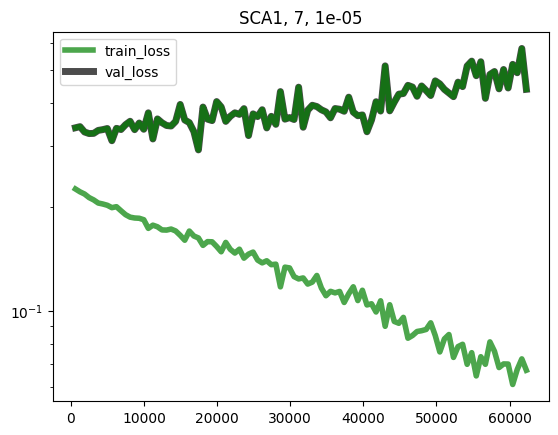

1 1


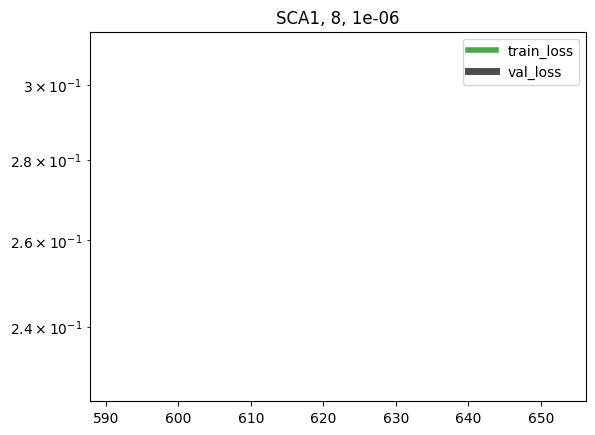

100 100


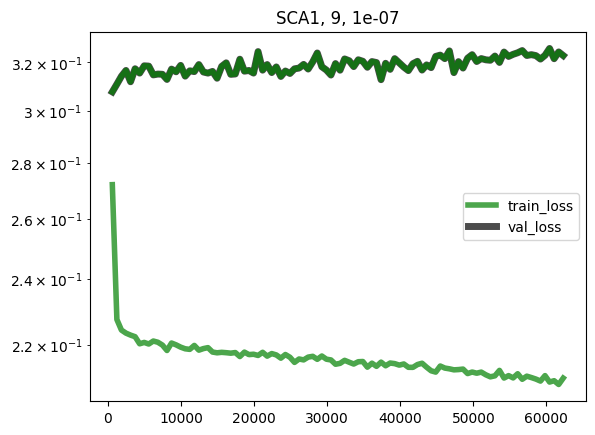

101 101


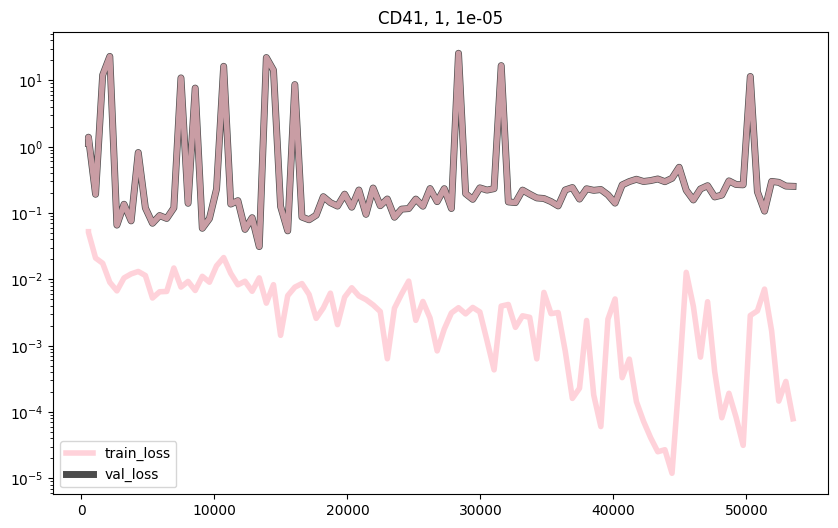

200 200


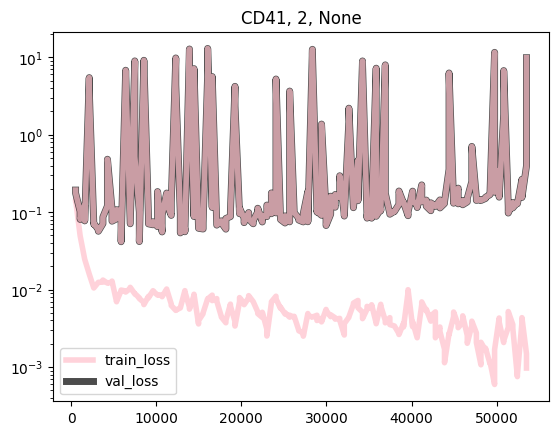

101 101


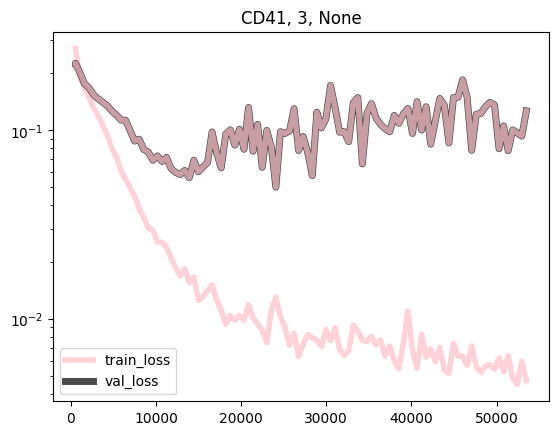

1 1


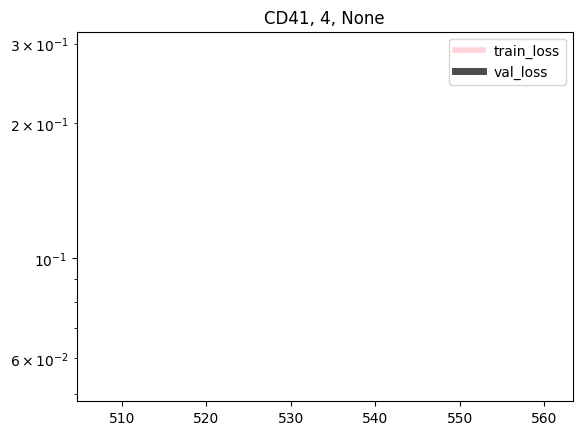

1 1


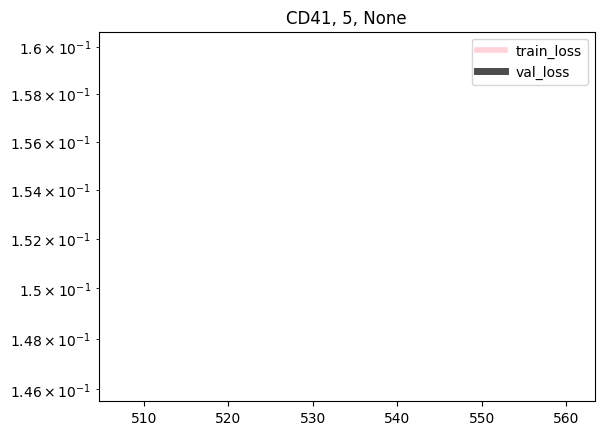

1 1


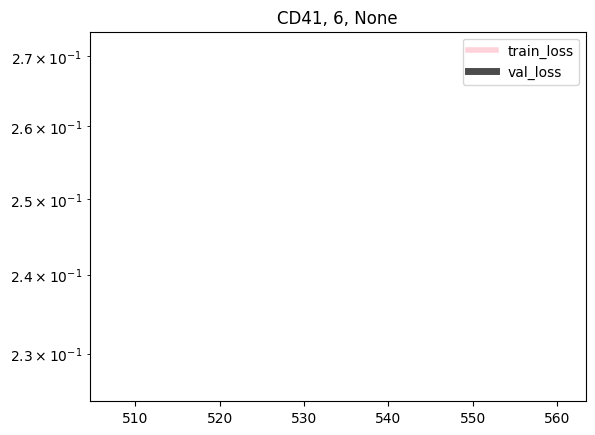

1 1


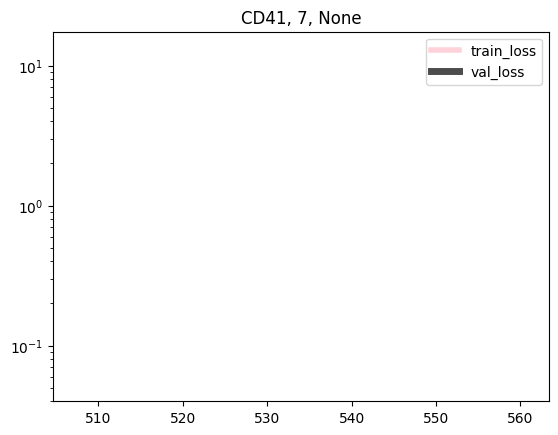

1 1


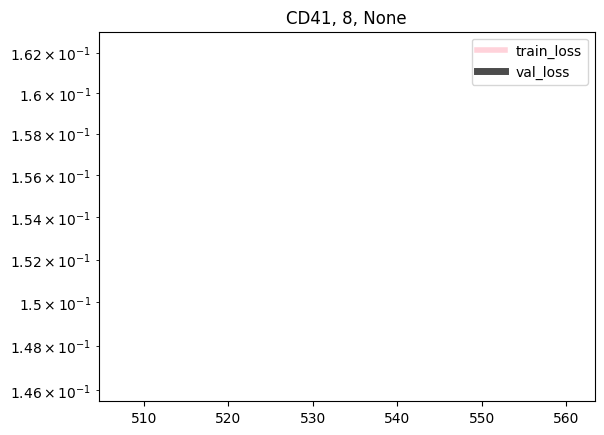

100 100


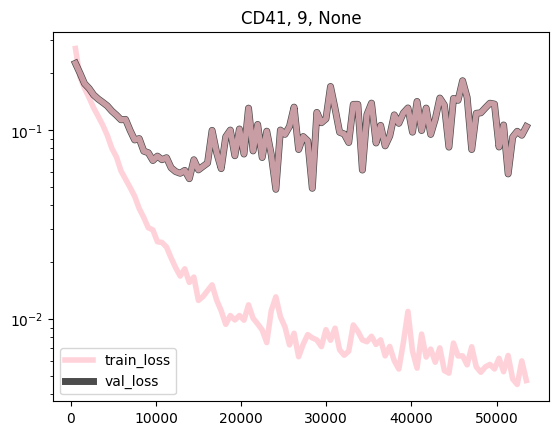

In [74]:
# maybe show how the val_loss behaves when compared to train_loss

# For each marker, generate its own line + scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

for marker in df['marker'].unique():
    # Filter the DataFrame to only include the current marker
    marker_df = df[df['marker'] == marker]
    # Filter to include metric of interest
    marker_df_val_loss = marker_df[marker_df['tag'] == 'val_loss']
    marker_df_training_loss_epoch = marker_df[marker_df['tag'] == 'training_loss_epoch']

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    plt.title(f"{marker}")

    # Create the line plot
    for instance in marker_df['instance'].unique():
        lr = marker_df[marker_df['instance'] == instance]['learning_rate'].values[0]
        instance_df_train = marker_df_training_loss_epoch[marker_df_training_loss_epoch['instance'] == instance]
        instance_df_train = instance_df_train.sort_values("step")
        instance_df_val = marker_df_val_loss[marker_df_val_loss['instance'] == instance]
        instance_df_val = instance_df_val.sort_values("step")
        

        # Print length of train and val
        print(len(instance_df_train), len(instance_df_val))

        plt.plot(instance_df_train['step'], instance_df_train['value'], color=palette[marker], linestyle='-', alpha=.7, linewidth=4)
        plt.plot(instance_df_val['step'], instance_df_val['value'], color='black', linestyle='-', alpha=.7, linewidth=5)
        plt.plot(instance_df_val['step'], instance_df_val['value'], color=palette[marker], linestyle='-', alpha=.7, linewidth=4)
        
        plt.yscale('log')
        plt.title(f"{marker}, {int(instance)}, {lr}")
        plt.legend(title='', labels=['train_loss', 'val_loss'])
        plt.show()


In [75]:
# CD41_3 check
check = df[df['file'] == 'CD41_3']
check

,tag,step,value,file,color,shape,instance,marker,learning_rate
13661,hp_metric,0,-1.000000,CD41_3,pink,p,3.0,CD41,0.0
13662,training_loss_step,9,0.567407,CD41_3,pink,p,3.0,CD41,0.0
13663,training_loss_step,19,0.343374,CD41_3,pink,p,3.0,CD41,0.0
13665,training_loss_step,39,0.314466,CD41_3,pink,p,3.0,CD41,0.0
13681,training_loss_step,199,0.183747,CD41_3,pink,p,3.0,CD41,0.0
...,...,...,...,...,...,...,...,...,...
13790,val_tn,534,1038.000000,CD41_3,pink,p,3.0,CD41,0.0
13789,val_tp,534,0.000000,CD41_3,pink,p,3.0,CD41,0.0
13788,val_loss,534,0.226126,CD41_3,pink,p,3.0,CD41,0.0
13787,epoch,619,1.000000,CD41_3,pink,p,3.0,CD41,0.0


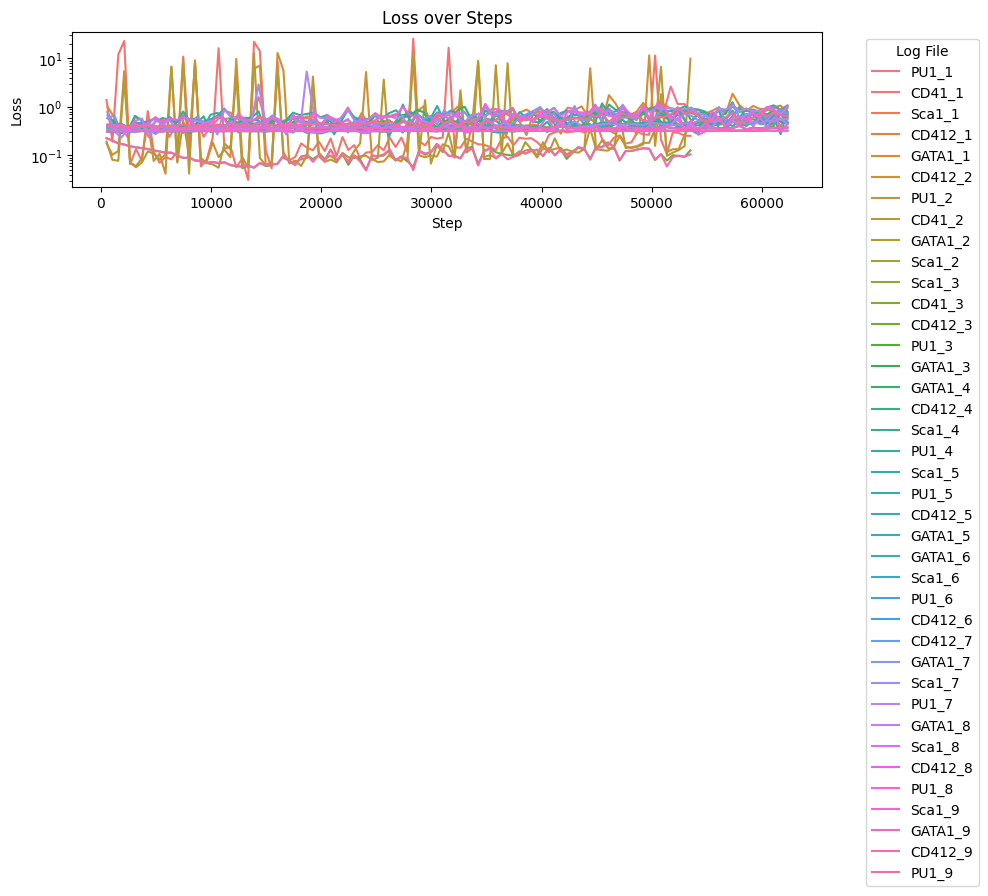

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific tag if needed, e.g., "loss"
df_loss = df[df["tag"] == "val_loss"]

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_loss, x="step", y="value", hue="file")
# sns.scatterplot(data=df_loss, x = "step", y = "value", markers = "shape", palette = "color")
plt.title("Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [77]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Print unique tags to check for correctness
# # print(df['tag'].unique())

# tags_of_interest = ['val_loss', 'val_accuracy', 'val_f1']#, 'training_loss_epoch']

# # Filter the DataFrame by the tags of interest
# df_training_loss_epoch = df[df["tag"] == "training_loss_epoch"]
# df_training_loss_step = df[df["tag"] == "training_loss_step"]

# # Display value counts of 'file' for each tag
# # print("Epoch-wise counts per file:\n", df_training_loss_epoch['file'].value_counts())
# # print("Step-wise counts per file:\n", df_training_loss_step['file'].value_counts())

# # Calculate the average number of steps per epoch for each log file
# steps_per_epoch = df_training_loss_step.groupby("file")["step"].max() / df_training_loss_epoch.groupby("file").size()

# # Round the steps per epoch
# steps_per_epoch_rounded = steps_per_epoch.round().astype(int)
# # Make it a multiple of 10
# steps_per_epoch_rounded = steps_per_epoch_rounded.apply(lambda x: x + (10 - x % 10) if x % 10 != 0 else x)
# print("Average steps per epoch:\n", steps_per_epoch_rounded)
# # print(df)

# df_ = df[df['tag'].isin(tags_of_interest)]
# print(df_['step'].unique())
# # Looks like only steps where epoch is ended are recorded.

# # add 'epoch' columns, which is the epoch number, which is the index of the sorted steps list for that file
# df_['epoch'] = df_.groupby('file')['step'].rank(method='dense').astype(int)
# print(df_['epoch'].unique())

In [78]:
for tag in tags_of_interest:
    df_tag = df[df["tag"] == tag]

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_tag, x="step", y="value", hue="file")
    plt.title(f"{tag} over steps")
    plt.xlabel("step")
    plt.ylabel(tag)
    # plt.yscale("log")
    plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

NameError: name 'tags_of_interest' is not defined

In [137]:
# def smooth_series(values, window_size=5):
#     return values.rolling(window=window_size, min_periods=1, center=True).mean()

# # Apply smoothing to your DataFrame
# df_loss['smoothed_value'] = df_loss.groupby("file")["value"].transform(lambda x: smooth_series(x, window_size=10))

# # Plot the smoothed data
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_loss, x="step", y="smoothed_value", hue="file")
# plt.title("Smoothed Loss over Steps")
# plt.xlabel("Step")
# plt.ylabel("Smoothed Loss")
# plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


/var/folders/33/8fj_gn7d4wj3r70mvvqjp9zh0000gn/T/ipykernel_25279/1754813208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss['smoothed_value'] = y


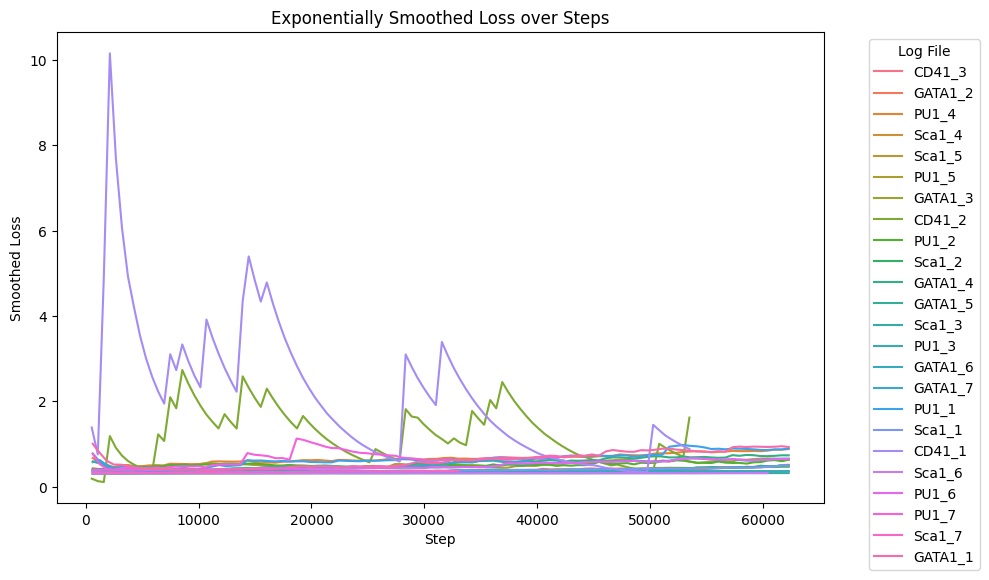

In [138]:
def exponential_moving_average(values, alpha=0.5):
    return values.ewm(alpha=alpha).mean()

# Apply exponential smoothing to your DataFrame
y = df_loss.groupby("file")["value"].transform(lambda x: exponential_moving_average(x, alpha=0.1))
df_loss['smoothed_value'] = y

# df_loss = df_loss[df_loss['file'] != 'version_12121098']

# Plot the smoothed data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_loss, x='step', y="smoothed_value", hue="file")
plt.title("Exponentially Smoothed Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Smoothed Loss")
plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
